## Demo to show how to get 3D profiles of galaxies in TNG

### This is a demo, so I'll be showing how to do this with one galaxy. But it's obviously easily to make this work for many galaxies.

In [1]:
# basic imports
import h5py
import numpy as np
import matplotlib.pyplot as plt

### List of the names of all the snapshot files and their paths:

- hr = high resolution, lr = low resolution. High resolution has more accurate info on the inner parts of the galaxies, while low resolution has better info for the outside edges of the galaxies.

- I'll only be using 1 file for this demo, but I thought it'd be helpful to show you all the file names

In [9]:
# list of files
file_list_lr_100 = ['galaxies_progmaps_lr_tng100_099.hdf5',
                    'galaxies_progmaps_lr_tng100_084.hdf5',
                    'galaxies_progmaps_lr_tng100_072.hdf5', 
                    'galaxies_progmaps_lr_tng100_067.hdf5',
                    'galaxies_progmaps_lr_tng100_059.hdf5', 
                    'galaxies_progmaps_lr_tng100_050.hdf5',
                    'galaxies_progmaps_lr_tng100_040.hdf5',
                    'galaxies_progmaps_lr_tng100_033.hdf5']

file_list_lr_300 = ['galaxies_progmaps_lr_tng300_099.hdf5',
                    'galaxies_progmaps_lr_tng300_084.hdf5',
                    'galaxies_progmaps_lr_tng300_072.hdf5', 
                    'galaxies_progmaps_lr_tng300_067.hdf5',
                    'galaxies_progmaps_lr_tng300_059.hdf5', 
                    'galaxies_progmaps_lr_tng300_050.hdf5',
                    'galaxies_progmaps_lr_tng300_040.hdf5',
                    'galaxies_progmaps_lr_tng300_033.hdf5',]

file_list_hr_300 = ['galaxies_progmaps_lr_tng300_099.hdf5',
                    'galaxies_progmaps_lr_tng300_084.hdf5',
                    'galaxies_progmaps_lr_tng300_072.hdf5', 
                    'galaxies_progmaps_lr_tng300_067.hdf5',
                    'galaxies_progmaps_lr_tng300_059.hdf5', 
                    'galaxies_progmaps_lr_tng300_050.hdf5',
                    'galaxies_progmaps_lr_tng300_040.hdf5',
                    'galaxies_progmaps_lr_tng300_033.hdf5',]


file_path_100= '/Users/sofia/Research/Data/TNG100/lr_tng100/'
file_path_300 = '/Users/sofia/Research/Data/TNG300/'

# using low res data for now
file_list = file_list_lr_300
file_path = file_path_300

### Grabbing basic information needed (constants, values, etc):

Note that I don't use all the information grabbed below in the code, but it's still helpful for a demo.

In [10]:
# constants
# value for h with h0 = 70 km s^-1 Mpc^-1
h = 0.7
box_size = 205 * 1000 #kpc

# some data sets at z = 0 and some of their fields
tng_data_099 = h5py.File(file_path + file_list[0], 'r')

# basic info for z = 0 snapshot
is_primary_099 = np.array(tng_data_099['catgrp_is_primary'])

# grab trees for convenience
tree_SnapNum = np.array(tng_data_099['tree_SnapNum'])
tree_subfind_id = np.array(tng_data_099['tree_subfind_id'])

# redshift and time lists
redshifts = np.array(tng_data_099['info']['tree_z']) 
snaps = np.array(tng_data_099['info']['tree_snaps'])

# snapshots we have and the redshifts at those snapshots
snapshots = [99, 84, 72, 67, 59, 50, 40]
snap_z = redshifts[snapshots]



## Defining some functions that will be useful:

- the function below is to find a specific galaxy across snapshots. We don't have an easily accessible set ID for each galaxy across snapshots, but have tree data instead.

In [4]:
# function written by joe to find ids of galaxies in different snapshot
#
# inputs: data at z=0, data at z!=0, snapshot number
#
def find_id(hdf0, hdf1, snapnum):
    ids = hdf0['tree_subfind_id'][:,snapnum]
    idx = hdf1['catsh_id'][:].argsort()

    match = hdf1['catsh_id'][:].searchsorted(ids, sorter=idx)
    goodmatch = hdf1['catsh_id'][:][idx][match]==ids

    # a check to makes sure the function is working (I commented it out for now)
    #print(np.isclose(hdf0['tree_SubhaloMassType'][:,snapnum,4][i], hdf1['scalar_star_mass'][:][idx][match][i]))
 
    return match, goodmatch, idx


- function to grab the 3d profiles from one galaxy at one snapshot. because I have to grab the data for a specific galaxy depending on if using the z=0 snapshot or not, I have to have an input "high_z" that tells me if z=0 (high_z = False if z=0, high_z = True if z!=0)
- as for what data I'm actually getting:
    - volume: volume in each "bin" (the galaxy is segmented into bins by radius)
    - bins: bins themselves
    - bound: mass within galaxy that is actually bound to galaxy
    - bound_ins: mass bound to galaxy created insitu (created within the galaxy itself)
    - bound_exs: mass bound to galaxy created exsitu (created outside the galaxy and found its way inside of it)
    - oshs: mass bound to *other* subhalos (other galaxies)
    - fuzz: mass not bound to any subhalo (any galaxy)

In [5]:
# function to find 3d masses for any snapshot
#
# inputs: data at some redshift, match (either goodmatch (z=0) or match (z!=0)), index of sat at z=0
#         high_z (False if z=0, True if z!=0)
def find_3d_masses(tng_data_z, match, idx, sat, high_z):    
    if high_z == False:
        volume = np.array(tng_data_z['profile_bins_volume'])[match][sat]
        bins = np.array(tng_data_z['profile_bins'])[match][sat]
        
        bound = np.array(tng_data_z['profile_star_rho_3d'])[match][sat]
        bound_ins = np.array(tng_data_z['profile_star_rho_insitu_3d'])[match][sat]
        bound_exs = np.array(tng_data_z['profile_star_rho_exsitu_3d'])[match][sat]
        
        oshs = np.array(tng_data_z['profile_star_rho_oshs_3d'])[match][sat]
        fuzz = np.array(tng_data_z['profile_star_rho_fuzz_3d'])[match][sat]

    if high_z == True:
        volume = np.array(tng_data_z['profile_bins_volume'])[idx][match[sat]]
        bins = np.array(tng_data_z['profile_bins'])[idx][match[sat]]
        
        bound = np.array(tng_data_z['profile_star_rho_3d'])[idx][match[sat]]
        bound_ins = np.array(tng_data_z['profile_star_rho_insitu_3d'])[idx][match[sat]]
        bound_exs = np.array(tng_data_z['profile_star_rho_exsitu_3d'])[idx][match[sat]]
        
        oshs = np.array(tng_data_z['profile_star_rho_oshs_3d'])[idx][match[sat]]
        fuzz = np.array(tng_data_z['profile_star_rho_fuzz_3d'])[idx][match[sat]]

    return bound, bound_ins, bound_exs, oshs, fuzz, volume, bins

## Let's create the file instances and initial info first:

Note: using a random snapshot for the demo (z=0.2)

In [17]:
# our random snapshot (just picked index of 1)
snap_index = 2
snapnum = snapshots[snap_index]

# instances of data at z=0 (snapshot 099) and random z (uysing snapshot at z=0.2)
tng_data_099 = h5py.File(file_path + file_list[0], 'r')
tng_data_z = h5py.File(file_path + file_list[snap_index], 'r')

# used to match galaxies across files
match, goodmatch, idx = find_id(tng_data_099, tng_data_z, snapnum)

# matcher = goodmatch if z=0. matcher = match if z!=0
matcher = match

# high_z = False if z=0. high_z = True if z!=0
high_z = True

## To use the functions, we still need a sat value. Also picking one at random (let's just say 60). Then we can use the functions above:

In [20]:
sat = 0

# call find_3d_masses from above to get 3d mass info
bound, bound_insitu, bound_exsitu, oshs, fuzz, volume, bins = find_3d_masses(tng_data_z, matcher, idx, sat, high_z)

## Quickly check to see if did it correctly with a plot:

- We also have:
    - m10 and m100 (as well as a way to find the 2D masses at any radius)
    - a way to find the 3D mass at any radius by integrating under the 3D data curve

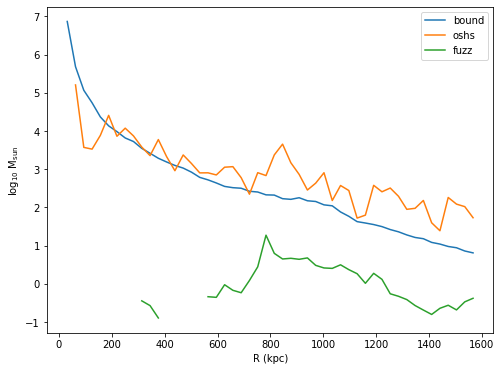

In [21]:
# ill be taking the log10 of an array, and that array has 0 values. so, replace 0s with NaN
oshs = np.where(oshs == 0, np.nan, oshs)
fuzz = np.where(fuzz == 0, np.nan, fuzz)

# just a simple plot. because a demo, doesn't need to be fancy.
plt.figure(figsize=(8,6))

plt.xlabel('R (kpc)')
plt.ylabel(r'$\mathrm{log_{10} \ M_{sun}}$')

plt.plot(bins, np.log10(bound), label='bound')
plt.plot(bins, np.log10(oshs), label='oshs')
plt.plot(bins, np.log10(fuzz), label='fuzz')

plt.legend()